In [79]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from operator import itemgetter
from itertools import groupby
import seaborn as sns

In [145]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [132]:
# Read the data in pandas
data = pd.read_csv("data_for_student_case.csv")
data['bookingdate'] =  pd.to_datetime(data['bookingdate'])
data['creationdate'] =  pd.to_datetime(data['creationdate'])

In [133]:
# Show the first entries
data.head()
# data['simple_journal'].unique()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


In [134]:
# Delete the refused transactions (but keep them for later use maybe)

refused_data = data.loc[data['simple_journal'] == "Refused", :]
dataset = data.loc[data['simple_journal'] != "Refused", :]
dataset['bool_fraud'] = (dataset['simple_journal'] == "Chargeback").copy().astype(int)
dataset['bool_valid'] = (dataset['simple_journal'] == "Settled").copy().astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [135]:
# Do some preprocessing for the ML algorithms
finalset = dataset.copy()
finalset['mail_id'] = finalset['mail_id'].str.replace('email','')
finalset['ip_id'] = finalset['ip_id'].str.replace('ip','')
finalset['card_id'] = finalset['card_id'].str.replace('card','')


In [136]:
# Group on dates
creation_dailygroup_mean = finalset.groupby(pd.Grouper(key='creationdate',freq='D')).mean()
creation_monthlygroup_mean = finalset.groupby(pd.Grouper(key='creationdate',freq='M')).mean()
booking_dailygroup_mean = finalset.groupby(pd.Grouper(key='bookingdate',freq='D')).mean()
booking_monthlygroup_mean = finalset.groupby(pd.Grouper(key='bookingdate',freq='M')).mean()

creation_dailygroup_sum = finalset.groupby(pd.Grouper(key='creationdate',freq='D')).sum()
creation_monthlygroup_sum = finalset.groupby(pd.Grouper(key='creationdate',freq='M')).sum()
booking_dailygroup_sum = finalset.groupby(pd.Grouper(key='bookingdate',freq='D')).sum()
booking_monthlygroup_sum = finalset.groupby(pd.Grouper(key='bookingdate',freq='M')).sum()

creation_dailygroup_count = finalset.groupby(pd.Grouper(key='creationdate',freq='D')).count()
creation_monthlygroup_count = finalset.groupby(pd.Grouper(key='creationdate',freq='M')).count()
booking_dailygroup_count = finalset.groupby(pd.Grouper(key='bookingdate',freq='D')).count()
booking_monthlygroup_count = finalset.groupby(pd.Grouper(key='bookingdate',freq='M')).count()

# Group on simple_journal
booking_monthlygroup_count = finalset.groupby(pd.Grouper(key='bookingdate',freq='M')).count()


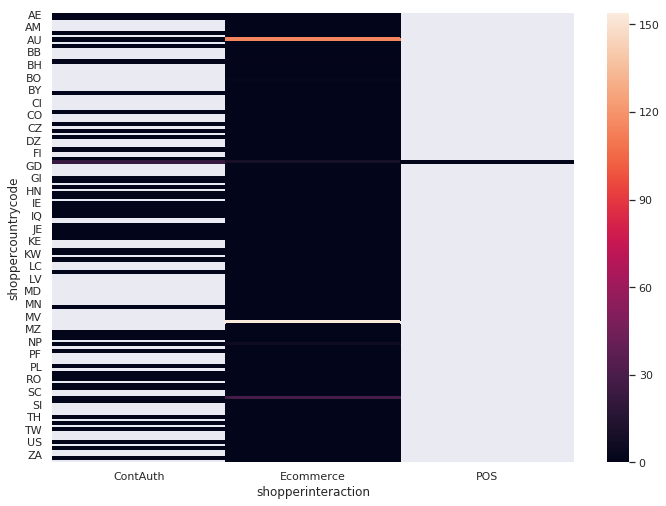

In [146]:
# Heatmap stuff
heatmap_data = pd.pivot_table(finalset, "simple_journal", "shoppercountrycode","shopperinteraction", aggfunc=lambda x: sum(x == "Chargeback"))
ax = sns.heatmap(heatmap_data)

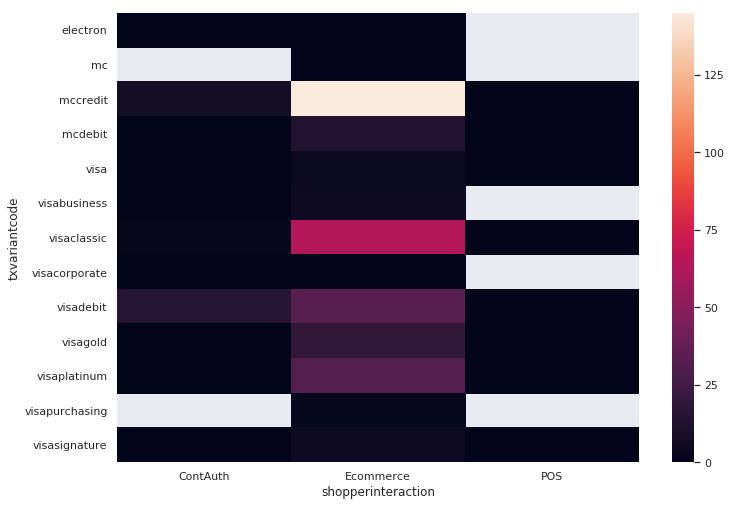

In [147]:
# Heatmap stuff
heatmap_data = pd.pivot_table(finalset, "simple_journal", "txvariantcode","shopperinteraction", aggfunc=lambda x: sum(x == "Chargeback"))
ax = sns.heatmap(heatmap_data)

[Text(0, 0, '2015-07-01'),
 Text(0, 0, '2015-07-02'),
 Text(0, 0, '2015-07-03'),
 Text(0, 0, '2015-07-04'),
 Text(0, 0, '2015-07-05'),
 Text(0, 0, '2015-07-06'),
 Text(0, 0, '2015-07-07'),
 Text(0, 0, '2015-07-08'),
 Text(0, 0, '2015-07-09'),
 Text(0, 0, '2015-07-10'),
 Text(0, 0, '2015-07-11'),
 Text(0, 0, '2015-07-12'),
 Text(0, 0, '2015-07-13'),
 Text(0, 0, '2015-07-14')]

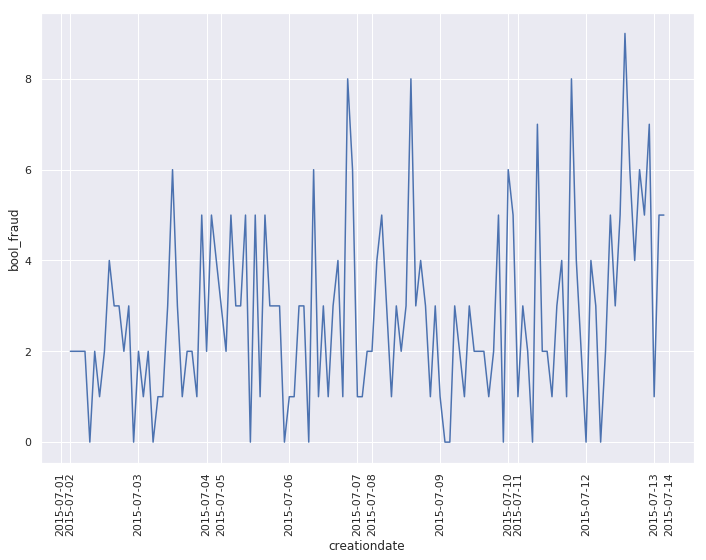

In [167]:
# multiple line plot
ax = sns.lineplot(x=creation_dailygroup_sum.index, y="bool_fraud", data=creation_dailygroup_sum)
ax.set_xticklabels(labels = [d.date() for d in creation_dailygroup_sum.index], rotation=90)

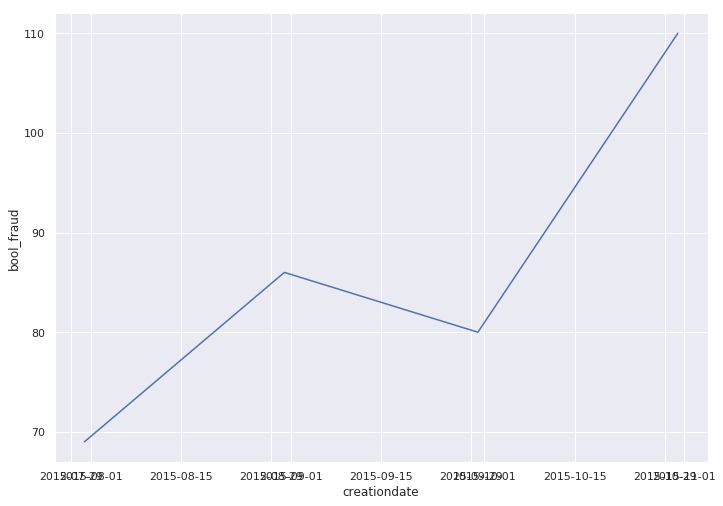

In [170]:
# multiple line plot
ax = sns.lineplot(x=creation_monthlygroup_sum.index, y="bool_fraud", data=creation_monthlygroup_sum)


In [171]:
creation_monthlygroup_sum.index

DatetimeIndex(['2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31'], dtype='datetime64[ns]', name='creationdate', freq='M')